# Exploratory data analysis of force of mortality data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
import seaborn as sns
import os

## 1. Importing the dataset
I use the same dataset as the DAV, in their notebook they mention the data is extracted from the Human Demography Database. It covers mortality rates for 11 countries or regions. There is data for both men and woman from ages 0 to 100. Missing data was imputed. 

Location of file: folder Data > mortality.csv

In [2]:
os.chdir("..")
MYwd= os.getcwd()
file_path = MYwd+"\Data\mortality.csv"

df = pd.read_csv(file_path)

# add a column with the mortality rates (originally, only the log_mortality rates are included)
df['mortality'] = np.exp(df['log_mortality'])

# the dataset contains data from west and east germany seperately. we only use the rates for the entire population of germany (DEUT)
df = df[(df['Country'].isin(["CHE","DEUT","DNK", "ESP", "FRATNP", "ITA", "JPN", "POL", "USA"]))]

print(df.head(10))
#print(df.info())

  Country  Year  Gender  Age  log_mortality  mortality
0     CHE  1950  Female    0      -3.601125   0.027293
1     CHE  1950  Female    1      -5.793926   0.003046
2     CHE  1950  Female    2      -6.392539   0.001674
3     CHE  1950  Female    3      -6.697494   0.001234
4     CHE  1950  Female    4      -6.900780   0.001007
5     CHE  1950  Female    5      -7.476916   0.000566
6     CHE  1950  Female    6      -7.374564   0.000627
7     CHE  1950  Female    7      -7.469874   0.000570
8     CHE  1950  Female    8      -7.492945   0.000557
9     CHE  1950  Female    9      -7.885921   0.000376


## 2. Exploratory data analysis

<Figure size 1008x576 with 0 Axes>

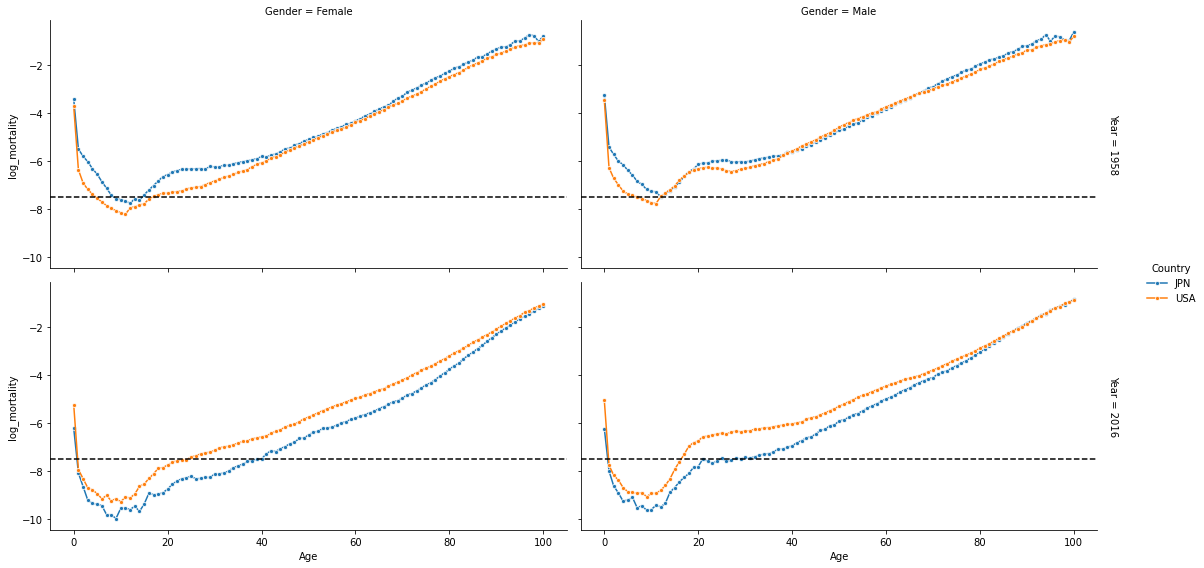

In [3]:
# filter some years and countries
filtered_df = df[(df['Year'].isin([1958, 2016])) & (df['Country'].isin(['JPN', 'USA']))]

# create the figure
plt.figure(figsize=(14, 8))

# create facetgrid for year and gender
g = sns.FacetGrid(filtered_df, col='Gender', row='Year', hue='Country', height=4, aspect=2, 
                  margin_titles=True)

g.map(sns.lineplot, 'Age', 'log_mortality', marker='o',markersize=4).add_legend()

# Add a horizontal line at y = -7.5
for ax in g.axes.flat:
    ax.axhline(y=-7.5, color="black", linestyle="--")

In [4]:
def lighten_cmap(cmap_name='winter', factor=0.5):
    """Lighten a given colormap by blending it with white."""
    base = cm.get_cmap(cmap_name)
    colors = base(np.linspace(0, 1, 256))
    white = np.ones((256, 4))  # RGBA for white
    colors = colors * (1 - factor) + white * factor
    return mcolors.ListedColormap(colors)

light_winter = lighten_cmap('winter', factor=0.3)

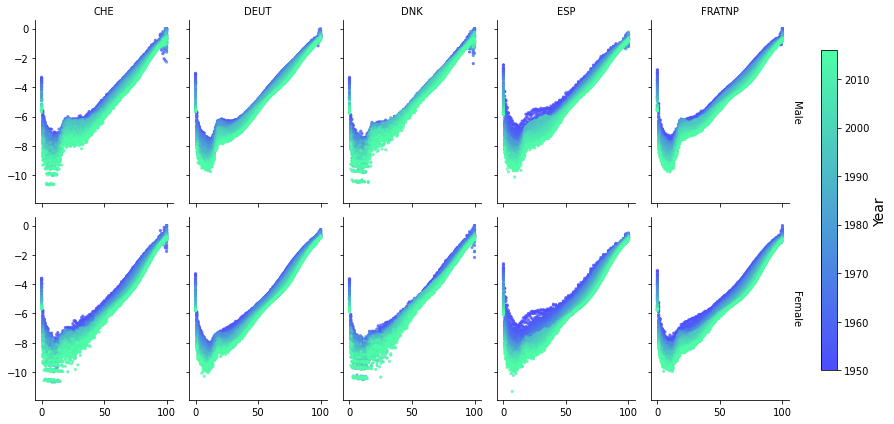

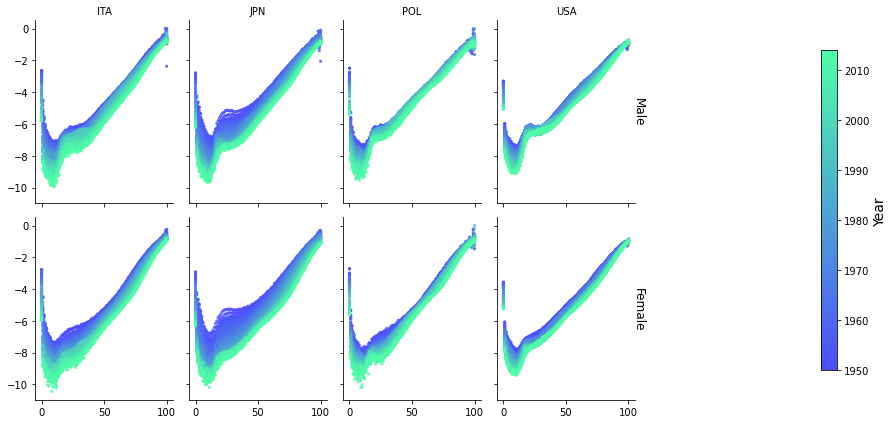

In [5]:
# Make sure Gender is ordered
df['Gender'] = pd.Categorical(df['Gender'], categories=['Male', 'Female'], ordered=True)

# Define fixed order of countries (use same in both figures)
all_countries = df['Country'].unique()
first_countries = all_countries[:5]
second_countries = all_countries[5:9]

# Custom scatterplot function
def custom_scatter(data, **kwargs):
    plt.scatter(data['Age'], data['log_mortality'], 
                c=data['Year'], cmap=light_winter, s=10, alpha=0.8, edgecolors='none')

# Pad second_countries with a placeholder so both lists have same length
second_countries_padded = list(second_countries) + ['(empty)']

# Add dummy rows for the '(empty)' column
dummy_rows = pd.DataFrame({
    'Country': ['(empty)'] * 2,  # one for each gender
    'Gender': ['Male', 'Female'],
    'Age': [0, 0],
    'log_mortality': [0, 0],
    'Year': [2000, 2000]
})
df_padded = pd.concat([df, dummy_rows], ignore_index=True)

# Create first grid
df1 = df[df['Country'].isin(first_countries)]
g1 = sns.FacetGrid(df1, row='Gender', col='Country', margin_titles=True,
                   height=3, aspect=0.8, row_order=['Male', 'Female'], col_order=first_countries)
g1.map_dataframe(custom_scatter)
g1.set_titles(row_template="{row_name}", col_template="{col_name}")

# Add colorbar using a dummy scatter (invisible, just for scale)
subset = df1[(df1['Country'] == df1['Country'].iloc[0]) & (df1['Gender'] == 'Male')]
scatter = plt.scatter(subset['Age'], subset['log_mortality'], c=subset['Year'], cmap=light_winter, s=0)

# Add shared colorbar to the whole grid
cbar = g1.fig.colorbar(scatter, ax=g1.axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Year', fontsize=14)

# Create second grid with dummy padded column
df2 = df_padded[df_padded['Country'].isin(second_countries_padded)]
g2 = sns.FacetGrid(df2, row='Gender', col='Country', margin_titles=True,
                   height=3, aspect=0.8,  row_order=['Male', 'Female'], col_order=second_countries_padded)
g2.map_dataframe(custom_scatter)
g2.set_titles(row_template="{row_name}", col_template="{col_name}")

# Add colorbar using a dummy scatter (invisible, just for scale)
subset = df2[(df2['Country'] == df2['Country'].iloc[0]) & (df2['Gender'] == 'Male')]
scatter = plt.scatter(subset['Age'], subset['log_mortality'], c=subset['Year'], cmap=light_winter, s=0)

# Add shared colorbar to the whole grid
cbar = g2.fig.colorbar(scatter, ax=g2.axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Year', fontsize=14)

# === Hide the (empty) subplot ===
for gender in ['Male', 'Female']:
    ax = g2.axes_dict[(gender, '(empty)')]
    ax.clear()
    ax.set_visible(False)

# === Manually add row labels (Male / Female) ===
# Determine visible countries (excluding the dummy one)
visible_countries = [c for c in second_countries_padded if c != '(empty)']

for gender in ['Male', 'Female']:
    # Get a visible axis in the first non-empty column
    ax = g2.axes_dict[(gender, visible_countries[0])]
    bbox = ax.get_position()

    # Compute center y-position of the subplot
    y_center = (bbox.y0 + bbox.y1) / 2

    # Place label on the right side of the figure (adjust x as needed)
    g2.fig.text(0.75, y_center, gender,
                fontsize=plt.rcParams['axes.titlesize'],  # match default title size
                va='center', ha='right', rotation=270)